<a href="https://colab.research.google.com/github/GabrielaCuervoR/Analitica3/blob/main/e_despliegue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd ### para manejo de datos
import sqlite3 as sql
import joblib
import openpyxl ## para exportar a excel
import numpy as np

[0 1 0 0 0]
['No' 'Yes']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   float64
 1   DistanceFromHome         4410 non-null   float64
 2   JobSatisfaction          4410 non-null   float64
 3   MaritalStatus_Single     4410 non-null   float64
 4   MonthlyIncome            4410 non-null   float64
 5   NumCompaniesWorked       4410 non-null   float64
 6   PercentSalaryHike        4410 non-null   float64
 7   TotalWorkingYears        4410 non-null   float64
 8   TrainingTimesLastYear    4410 non-null   float64
 9   YearsAtCompany           4410 non-null   float64
 10  YearsSinceLastPromotion  4410 non-null   float64
 11  YearsWithCurrManager     4410 non-null   float64
dtypes: float64(12)
memory usage: 413.6 KB
Best Params:  {'max_depth': 14, 'max_leaf_nodes': 300, 'n_estimators'

<Figure size 792x792 with 0 Axes>

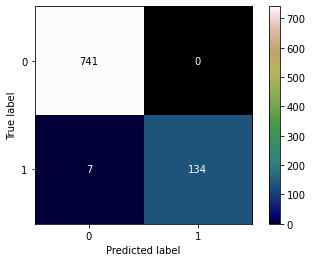

In [ ]:
%run c_modelos.ipynb

In [ ]:
import a_funciones as funciones

In [ ]:
def preparar_datos (df):

  #### Cargar modelo y listas


  list_cat=joblib.load("list_cat.pkl")
  list_num=joblib.load("list_num.pkl")
  list_dummies=joblib.load("list_dummies.pkl")
  var_names=joblib.load("var_names.pkl")
  scaler=joblib.load( "scaler.pkl")

  ####Ejecutar funciones de transformaciones

  df=funciones.imputar_fc(df,list_cat)
  df=funciones.imputar_fn(df,list_num)
  df_dummies=pd.get_dummies(df,columns=list_dummies)
  df_dummies= df_dummies.loc[:,~df_dummies.columns.isin(['Attrition','EmployeeID'])]
  X2=scaler.transform(df_dummies)
  X=pd.DataFrame(X2,columns=df_dummies.columns)
  X=X[var_names]


  return X

In [ ]:
###### el despliegue consiste en dejar todo el código listo para una ejecucion automática en el periodo definido:
###### en este caso se ejecutara el proceso de entrenamiento y prediccion anualmente.
if __name__=="__main__":


  ### conectarse a la base de datos ###
  conn=sql.connect("db_empleados")
  cur=conn.cursor()

  ### Ejecutar sql de preprocesamiento inicial y juntarlo
  #### con base de preprocesamiento con la que se entrenó para evitar perdida de variables por conversión a dummies

  funciones.ejecutar_sql('preprocesamiento.sql',cur) ### con las fechas actualizadas explicativas 2023- predecir 2024
  df=pd.read_sql('''select  * from base_nueva''',conn)
  df = df.drop(['Over18','EmployeeCount','index'], axis = 1) #eliminación de variables de una sola categoria

  ####Otras transformaciones en python (imputación, dummies y seleccion de variables)
  df_t= preparar_datos(df)


  ##Cargar modelo y predecir
  bestModel_rfc = joblib.load("bestModel_rfc.pkl")
  predicciones=bestModel_rfc.predict(df_t)
  pd_pred=pd.DataFrame(predicciones, columns=['pred_2017'])


  ###Crear base con predicciones ####

  perf_pred=pd.concat([df['EmployeeID'],df_t,pd_pred],axis=1)

  ####LLevar a BD para despliegue
  perf_pred.loc[:,['EmployeeID', 'pred_2017']].to_sql("perf_pred",conn,if_exists="replace") ## llevar predicciones a BD con ID Empleados


  ####ver_predicciones_bajas ###
  emp_pred_bajo=perf_pred.sort_values(by=["pred_2017"],ascending=True).head(10)

  emp_pred_bajo.set_index('EmployeeID', inplace=True)
  pred=emp_pred_bajo.T

  importancia1 = bestModel_rfc.feature_importances_   #importancia de las variables seleccionadas
  importancia1 = pd.DataFrame(importancia1, columns=['Importancia'])
  X3 = pd.DataFrame(X2.columns, columns=['Variables'])
  # Concatenar las Series al DataFrame X2
  variables_con_importancias = pd.concat([X3, importancia1], axis=1)
  variables_con_importancias.to_excel("variables_con_importancias.xlsx") ### exportar importancia de variables para análisis personalizado